In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt 
import seaborn as sns

In [23]:
df = pd.read_csv('smart_home_energy_consumption_large.csv')

In [24]:
df.head()

,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Home ID                   100000 non-null  int64  
 1   Appliance Type            100000 non-null  object 
 2   Energy Consumption (kWh)  100000 non-null  float64
 3   Time                      100000 non-null  object 
 4   Date                      100000 non-null  object 
 5   Outdoor Temperature (°C)  100000 non-null  float64
 6   Season                    100000 non-null  object 
 7   Household Size            100000 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.1+ MB


In [26]:
df.describe()

,Home ID,Energy Consumption (kWh),Outdoor Temperature (°C),Household Size
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,250.374980,1.499952,14.950135,3.001770
std,144.435367,1.181176,14.438755,1.417077
min,1.000000,0.100000,-10.000000,1.000000
25%,125.000000,0.590000,2.400000,2.000000
50%,250.000000,1.230000,14.900000,3.000000
75%,375.000000,1.870000,27.400000,4.000000
max,500.000000,5.000000,40.000000,5.000000


In [27]:
df.isna().sum()

Home ID                     0
Appliance Type              0
Energy Consumption (kWh)    0
Time                        0
Date                        0
Outdoor Temperature (°C)    0
Season                      0
Household Size              0
dtype: int64

/tmp/ipykernel_6668/4124159291.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_appliances.values, y=top_appliances.index, palette='viridis')


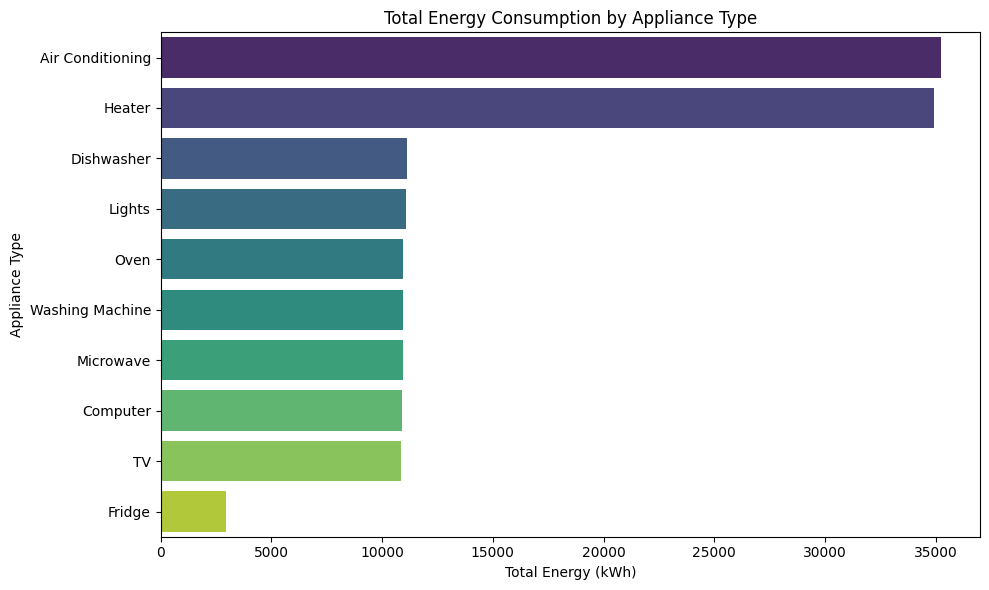

In [28]:
plt.figure(figsize=(10, 6))
top_appliances = df.groupby('Appliance Type')['Energy Consumption (kWh)'].sum().sort_values(ascending=False)
sns.barplot(x=top_appliances.values, y=top_appliances.index, palette='viridis')
plt.title('Total Energy Consumption by Appliance Type')
plt.xlabel('Total Energy (kWh)')
plt.ylabel('Appliance Type')
plt.tight_layout()
plt.show()


### Feature Engineering

In [29]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Date'] = df['Datetime'].dt.date

# Aggregate: per home per day usage behavior
daily_usage = df.groupby(['Home ID', 'Date']).agg({
    'Energy Consumption (kWh)': ['sum', 'mean', 'max', 'count'],
    'Outdoor Temperature (°C)': 'mean',
    'Household Size': 'first'
})

daily_usage.columns = ['Total_Consumption', 'Avg_Per_Appliance', 'Max_Single_Appliance', 'Appliance_Count',
                       'Avg_Temp', 'Household_Size']
daily_usage.reset_index(inplace=True)

daily_usage['Date'] = pd.to_datetime(daily_usage['Date'])
daily_usage['Month'] = daily_usage['Date'].dt.month
daily_usage['DayOfWeek'] = daily_usage['Date'].dt.dayofweek
daily_usage['IsWeekend'] = daily_usage['DayOfWeek'].isin([5, 6]).astype(int)


### Train/Test Split

In [30]:
X = daily_usage[['Avg_Temp', 'Household_Size', 'Avg_Per_Appliance',
                 'Max_Single_Appliance', 'Appliance_Count', 'Month', 'DayOfWeek', 'IsWeekend']]
y = daily_usage['Total_Consumption']

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

## Model Evaluation

In [31]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

Model Evaluation:
Mean Squared Error: 0.13
R² Score: 0.9466


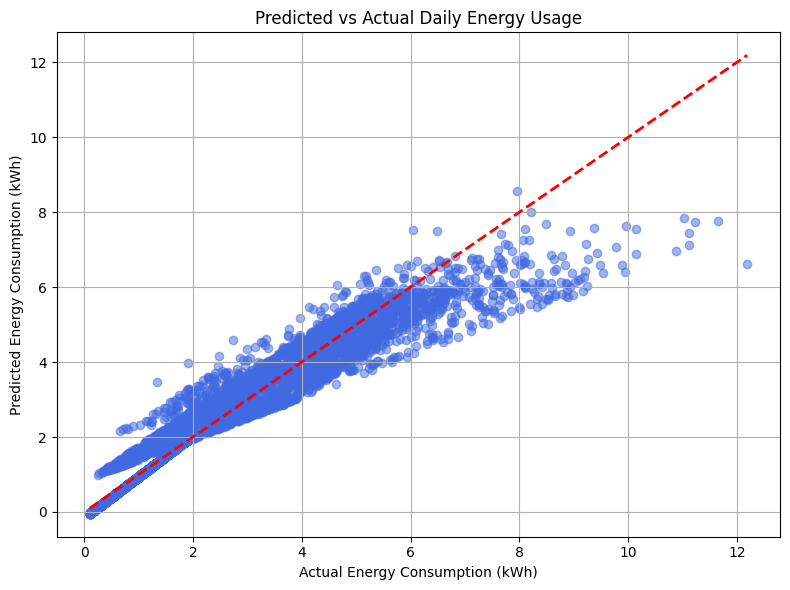

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Energy Consumption (kWh)')
plt.ylabel('Predicted Energy Consumption (kWh)')
plt.title('Predicted vs Actual Daily Energy Usage')
plt.grid(True)
plt.tight_layout()
plt.show()


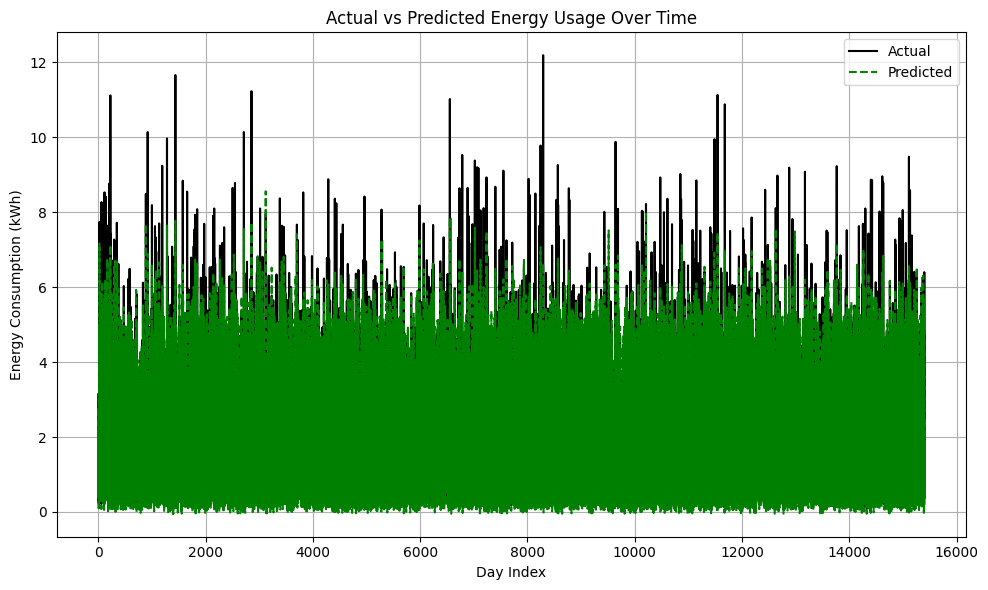

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual', color='black')
plt.plot(y_pred
, label='Predicted', color='green', linestyle='--')
plt.title('Actual vs Predicted Energy Usage Over Time')
plt.xlabel('Day Index')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
joblib.dump(pipeline, 'energy_consumption_model.pkl')


['energy_consumption_model.pkl']